## Cancer Outcome Analysis

#### Set up

In [10]:
# import os
# print(os.getcwd()) 

/Users/sungeun


In [106]:
# os.chdir("/Users/")

In [105]:
# print(os.getcwd()) 

### Pivot Incidence and Death Rate

In [32]:
import pandas as pd

df=pd.read_csv("2. Table 5. Death Rates.csv")
# df=pd.read_csv("1. Table 4. Incidence Rates.csv")

In [33]:
df.head()

,State,All sites Male,All sites Female,Breast Female,Colon & rectum Male,Colon & rectum Female,Lung & bronchus Male,Lung & bronchus Female,Non-Hodgkin lymphoma Male,Non-Hodgkin lymphoma Female,Pancreas Male,Pancreas Female,Prostate Male
0,Alabama,197.6,133.2,20.4,17.6,11.8,53.3,30.7,6.3,3.2,13.4,10.0,19.9
1,Alaska,172.3,129.3,17.1,14.8,13.1,34.2,29.8,6.7,4.4,11.0,9.0,21.8
2,Arizona,155.5,117.1,18.8,14.8,10.2,29.8,23.5,5.9,3.4,12.0,9.0,17.6
3,Arkansas,205.4,140.6,19.8,18.2,12.3,56.6,37.1,6.9,3.8,13.3,9.5,19.8
4,California,155.8,116.5,18.8,14.2,10.2,27.5,20.0,6.2,3.6,11.9,9.2,20.2


In [35]:
# Pivot 
df_pivot = df.melt(
    id_vars=["State"],
    var_name="Cancer_Sex",
#     value_name="Incidence"
    value_name="Death"
)

df_pivot.head()

,State,Cancer_Sex,Death
0,Alabama,All sites Male,197.6
1,Alaska,All sites Male,172.3
2,Arizona,All sites Male,155.5
3,Arkansas,All sites Male,205.4
4,California,All sites Male,155.8


In [36]:
# Split 'Cancer_Sex'
df_pivot[["Cancer_Type", "Sex"]] = df_pivot["Cancer_Sex"].str.rsplit(" ",n=1, expand=True)
df_pivot = df_pivot.drop(columns=["Cancer_Sex"])
# df_pivot = df_pivot[["State", "Cancer_Type", "Sex", "Incidence"]]
df_pivot = df_pivot[["State", "Cancer_Type", "Sex", "Death"]]
df_pivot = df_pivot.sort_values(by=["State", "Cancer_Type"])
df_pivot = df_pivot.reset_index(drop=True)

df_pivot.head()

,State,Cancer_Type,Sex,Death
0,Alabama,All sites,Male,197.6
1,Alaska,All sites,Male,172.3
2,Arizona,All sites,Male,155.5
3,Arkansas,All sites,Male,205.4
4,California,All sites,Male,155.8


In [39]:
# df_pivot.to_csv("2. Table 5. Death Rates_PIVOT.csv", index=False)

#### Compute correlation of Incidence and Death rate


In [89]:
df_IN = pd.read_csv("1. Table 4. Incidence Rates_PIVOT.csv")
df_DE = pd.read_csv("2. Table 5. Death Rates_PIVOT.csv")
df_INDE = pd.merge(df_IN, df_DE, on=["State","Cancer_Type","Sex"])
df_INDE.head()

,State,Cancer_Type,Sex,Incidence,Death
0,Alabama,All sites,Male,495.0,197.6
1,Alabama,All sites,Female,404.3,133.2
2,Alabama,Breast,Female,125.2,20.4
3,Alabama,Colon & rectum,Male,45.2,17.6
4,Alabama,Colon & rectum,Female,33.6,11.8


In [90]:

corr, p_value = pearsonr(df_INDE["Incidence"], df_INDE["Death"])
print(f"Pearson correlation: {corr:.3f}, p-value: {p_value:.3g}")

Pearson correlation: 0.963, p-value: 6.78e-286


### Create MIR

First, merge two data sets.

In [31]:
import pandas as pd

# Load your CSVs
df_IN = pd.read_csv("1. Table 4. Incidence Rates.csv")
df_DE = pd.read_csv("2. Table 5. Death Rates.csv")

# Keep States + selected columns
df_IN_filtered = df_IN[["State", "All sites Male", "All sites Female"]]
df_DE_filtered = df_DE[["State", "All sites Male", "All sites Female"]]

# Merge on States
df = pd.merge(
    df_IN_filtered,
    df_DE_filtered,
    on="State",
    suffixes=("_Incidence", "_Death")
)

# Reshape to long format
df_long = pd.melt(
    df,
    id_vars=["State"],
    value_vars=[
        "All sites Male_Incidence", "All sites Female_Incidence",
        "All sites Male_Death", "All sites Female_Death"
    ],
    var_name="Metric",
    value_name="Value"
)

# Extract Sex and Type from Metric
df_long["Sex"] = df_long["Metric"].apply(lambda x: "Male" if "Male" in x else "Female")
df_long["Type"] = df_long["Metric"].apply(lambda x: "Incidence" if "Incidence" in x else "Death")

# Pivot so each row = State + Sex, columns = Incidence/Death
df_final = df_long.pivot_table(
    index=["State", "Sex"],
    columns="Type",
    values="Value"
).reset_index()

# Calculate Mortality-to-Incidence Ratio (MIR)
df_final["MIR"] = round((df_final["Death"] / df_final["Incidence"]) * 100,2)  # percentage

df_final.head()

Type,State,Sex,Death,Incidence,MIR
0,Alabama,Female,133.2,404.3,32.95
1,Alabama,Male,197.6,495.0,39.92
2,Alaska,Female,129.3,422.2,30.63
3,Alaska,Male,172.3,460.7,37.40
4,Arizona,Female,117.1,384.9,30.42


In [32]:
# df_final.to_csv("3. Mortality-to-Incidence.csv", index=False)

In [57]:
# Select Top 10 and Bottom 10 states for female
top10_female = (
    df_final[df_final["Sex"] == "Female"]   
    .sort_values("MIR", ascending=False)    # sort by MIR descending
    .head(10)[["State", "MIR"]].reset_index(drop=True) 
)
bottom10_female = (
    df_final[df_final["Sex"] == "Female"]  
    .sort_values("MIR")   
    .head(10)[["State", "MIR"]].reset_index(drop=True)            
)

bottom10_female

Type,State,MIR
0,New York,25.20
1,Connecticut,25.90
2,Hawaii,25.94
3,New Jersey,25.97
4,Minnesota,26.22
5,Florida,26.62
6,Utah,27.05
7,North Dakota,27.07
8,New Hampshire,27.09
9,Iowa,27.17


In [58]:
# Select Top 10 and Bottom 10 states for male
top10_male = (
    df_final[df_final["Sex"] == "Male"]  
    .sort_values("MIR", ascending=False)   
    .head(10)[["State", "MIR"]].reset_index(drop=True)           
)
bottom10_male = (
    df_final[df_final["Sex"] == "Male"]  
    .sort_values("MIR")   
    .head(10)[["State", "MIR"]].reset_index(drop=True)       
)

bottom10_male

Type,State,MIR
0,New Jersey,28.53
1,New York,28.73
2,Utah,29.75
3,Connecticut,31.25
4,Minnesota,31.61
5,Florida,32.07
6,North Dakota,32.45
7,Iowa,32.52
8,Idaho,32.58
9,Montana,32.79


### t-test for top and bottom state groups
#### Are the top MIR states significantly different from the bottom MIR states?
Independent t-test (assuming unequal variance)

Interpretation:

p < 0.05 → MIRs of top and bottom states are significantly different.

p ≥ 0.05 → Difference is not statistically significant.

In [41]:
from scipy.stats import ttest_ind
# For female
t_stat, p_value = ttest_ind(top10_female['MIR'], bottom10_female['MIR'], equal_var=False)

print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_value:.3f}")

T-statistic: 14.916
P-value: 0.000


In [60]:
# For male
t_stat, p_value = ttest_ind(top10_male['MIR'], bottom10_male['MIR'], equal_var=False)

print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_value:.3f}")

T-statistic: 15.022
P-value: 0.000


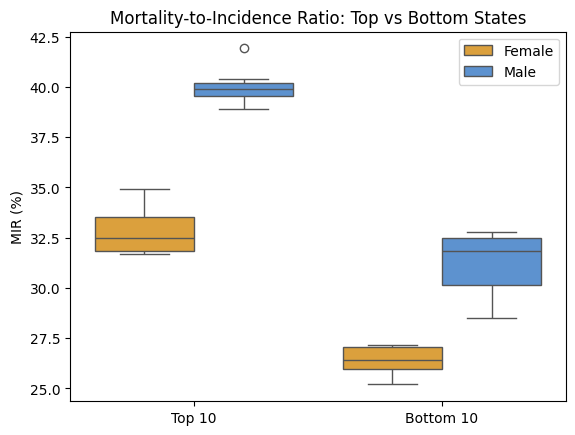

In [104]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create combined dataframe
df_plot = pd.DataFrame({
    'Group': (['Top 10']*10 + ['Bottom 10']*10)*2,
    'MIR': list(top10_female['MIR']) + list(bottom10_female['MIR']) +
           list(top10_male['MIR']) + list(bottom10_male['MIR']),
    'Sex': ['Female']*20 + ['Male']*20
})

# Boxplot with hue by Sex
colors = {"Male": "#4A90E2", "Female": "#F5A623"}
sns.boxplot(x="Group", y="MIR", hue="Sex", data=df_plot, palette=colors)

# Overlay stripplot
# sns.stripplot(x="Group", y="MIR", hue="Sex", data=df_plot,
#               dodge=True, jitter=True, color="black", marker="o", alpha=0.6)

plt.title("Mortality-to-Incidence Ratio: Top vs Bottom States")
plt.ylabel("MIR (%)")
plt.xlabel("")

# Fix duplicate legends from boxplot + stripplot
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[0:2], labels[0:2])

plt.show()

### Correlation of MIR and Health Care Ranking
> dfd

In [70]:
df_ranking = pd.read_csv("3. Health Care Ranking.csv")
# df_final.to_csv("3. Mortality-to-Incidence.csv", index=False)
df_MIR_rank = pd.merge(df_final, df_ranking, on="State")

df_MIR_rank.head()

,State,Sex,Death,Incidence,MIR,Ranking
0,Alabama,Female,133.2,404.3,32.95,42
1,Alabama,Male,197.6,495.0,39.92,42
2,Alaska,Female,129.3,422.2,30.63,38
3,Alaska,Male,172.3,460.7,37.40,38
4,Arizona,Female,117.1,384.9,30.42,34


In [71]:
# df_MIR_rank.to_csv("3. MIR_rank.csv", index=False)

#### Pearson Correlation (linear relationship)

In [73]:
from scipy.stats import pearsonr

# Compute correlation
corr, p_value = pearsonr(df_MIR_rank["MIR"], df_MIR_rank["Ranking"])
print(f"Pearson correlation: {corr:.3f}, p-value: {p_value:.3g}")

Pearson correlation: 0.410, p-value: 2.29e-05


corr → ranges between -1 and 1

p_value → tells you if the correlation is statistically significant (< 0.05 usually)

#### Spearman Correlation (rank-based, robust for non-linear)

Since healthcare rankings are ordinal (1st = best, etc.), Spearman is often better:

In [74]:
from scipy.stats import spearmanr

corr, p_value = spearmanr(df_MIR_rank["MIR"], df_MIR_rank["Ranking"])
print(f"Spearman correlation: {corr:.3f}, p-value: {p_value:.3g}")

Spearman correlation: 0.402, p-value: 3.42e-05


In [83]:
# Filter only Female rows
df_MIR_rank_female = df_MIR_rank[df_MIR_rank["Sex"] == "Female"]

# Spearman correlation for females only
corr, p_value = spearmanr(df_MIR_rank_female["MIR"], df_MIR_rank_female["Ranking"])

print(f"Spearman correlation (Female): {corr:.3f}, p-value: {p_value:.3g}")

Spearman correlation (Female): 0.706, p-value: 1.05e-08


In [85]:
# Filter only Female rows
df_MIR_rank_male = df_MIR_rank[df_MIR_rank["Sex"] == "Male"]

# Spearman correlation for females only
corr, p_value = spearmanr(df_MIR_rank_male["MIR"], df_MIR_rank_male["Ranking"])

print(f"Spearman correlation (male): {corr:.3f}, p-value: {p_value:.3g}")

Spearman correlation (male): 0.550, p-value: 3.53e-05


#### Scatter Plot

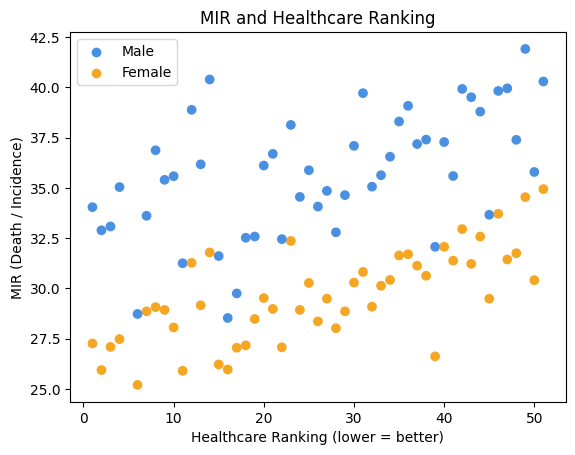

In [101]:
import matplotlib.pyplot as plt

# Scatter plot, coloring by sex
colors = {"Male": "#4A90E2", "Female": "#F5A623"}

plt.scatter(df_MIR_rank["Ranking"], df_MIR_rank["MIR"], c=df_MIR_rank["Sex"].map(colors))
for sex, color in colors.items():
    plt.scatter([], [], c=color, label=sex)
plt.xlabel("Healthcare Ranking (lower = better)")
plt.ylabel("MIR (Death / Incidence)")
plt.legend()
plt.title("MIR and Healthcare Ranking")
plt.show()
